<a href="https://colab.research.google.com/github/Ayan-Vishwakarma/Keras-Implementation-of-Dense-and-DC-NSGAN-WGAN-WGANGP-etc/blob/main/NSGAN_and_WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import *

In [3]:
(xt,_),(_,_) = keras.datasets.mnist.load_data()
xt.resize((60000,28,28,1))
xt = xt/127.5 - 1.
assert (np.max(xt) == 1. and np.min(xt) == -1.)

11493376/11490434 [==============================] - 0s 0us/step


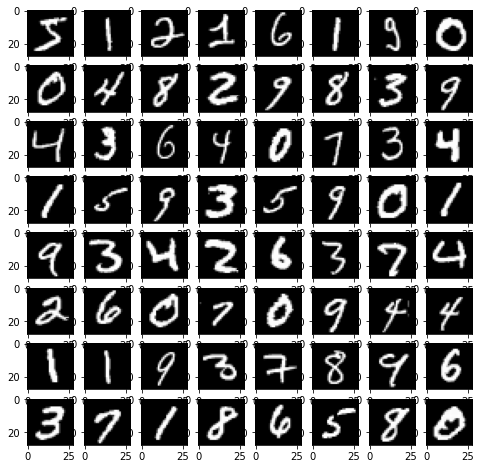

In [4]:
fig,ax = plt.subplots(8,8,figsize=(8,8))

for i in range(64):
  ax[i%8,i//8].imshow(xt[i].reshape((28,28)),cmap="gray")

Minmax not used since it saturates when generator performs bad and when the generator performs good,the gradients are too high to be used.
Minmax being the most unstable is never used.
 
 Instead NS-GAN, WGAN and WGAN-GP are used

Each of the 9 models are used to generate mnist images. DC-generator with Dense-discriminator model was the most stable GAN model however DCGAN model performed best.

## NS-GAN

Binary_crossentropy loss is used for discriminator.While training generator the labels are fipped in which case the models less saturates when generator performs bad and gradients are small when generator performs good. However, magnitude of gradients are still high when generator performs bad and model is still highly unstable, which is stablized by tuning learning rates.

Gotchas:

1.Loss should never become less than e-5. 

2.Discriminator acc should be greater than 0.7 while gan acc should be less than 0.3 for stable models. 

3.Any model can be made stable just by tuning learing_rate which is tedious task.RmsProp was preferred for this with learning rates 0.0002 and 0.00005 seen in most papers.

4.Tanh is preferred for generator with LeakyReLU with 0.2 threshold.It must be asserted that samples coming from generator and real examples come from same space.

In [5]:
def sample_images(generator):
  imgs = generator.predict(np.random.randn(16,z))
  fig,ax = plt.subplots(4,4,sharex=True,sharey=True,figsize = (4,4))
  for i in range(16):
    ax[i%4,i//4].imshow(imgs[i].reshape(28,28),cmap="gray")

In [16]:
def training_loop(n_iter,batch_size,sampling_interval):
  losses = []
  accuracies = [] 
  for i in range(n_iter):

    ind = np.random.randint(60000,size = batch_size)
    w1 = discriminator.train_on_batch(xt[ind],np.ones((batch_size)))
    w2 = discriminator.train_on_batch(generator(np.random.randn(batch_size,z)),np.zeros(batch_size))
    w = np.add(w1,w2)/2
    losses.append(w[0])
    accuracies.append(w[1])

    w = gan.train_on_batch(np.random.randn(batch_size,z),np.ones(batch_size))

    if i%sampling_interval == 0:
      print(i)
      print(losses[-1],accuracies[-1])
      print(w)
      print()
      sample_images(generator)
  return losses

### NS-GAN Dense-Generator Dense-Discriminator








In [23]:
th = 0.2
z = 100

discriminator = keras.Sequential()
discriminator.add(Reshape((784,),input_shape=(28,28,1)))
discriminator.add(Dense(1024))
discriminator.add(LeakyReLU(th))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(th))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(th))
discriminator.add(Dense(1,activation="sigmoid"))

discriminator.compile(loss = "binary_crossentropy",optimizer = keras.optimizers.RMSprop(0.0002),metrics = ["acc"])
discriminator.trainable = False

generator = keras.Sequential()
generator.add(Dense(256,input_dim = z))
generator.add(LeakyReLU(th))
generator.add(Dense(512))
generator.add(LeakyReLU(th))
generator.add(Dense(1024))
generator.add(LeakyReLU(th))
generator.add(Dense(784,activation ="tanh"))
generator.add(Reshape((28,28,1)))

gan = keras.Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss = "binary_crossentropy",optimizer = keras.optimizers.RMSprop((0.0002)),metrics=["acc"])

assert ((gan.layers[0].trainable==True) and (gan.layers[1].trainable==False))

0
0.625661313533783 0.5
[0.8950157165527344, 0.0]

1000
0.254841111600399 0.90625
[3.3244705200195312, 0.0]

2000
0.40929578244686127 0.81640625
[2.361577033996582, 0.015625]

3000
0.39657823741436005 0.828125
[1.7340970039367676, 0.0]

4000
0.41191428899765015 0.81640625
[1.697385549545288, 0.015625]

5000
0.4230341911315918 0.8046875
[1.6555049419403076, 0.015625]

6000
0.4454842209815979 0.8203125
[1.6469498872756958, 0.0078125]

7000
0.39603596925735474 0.828125
[1.6729726791381836, 0.015625]



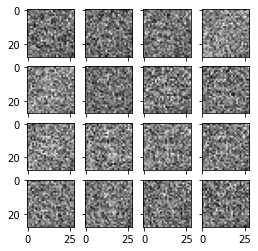

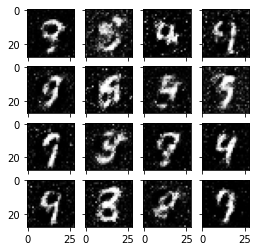

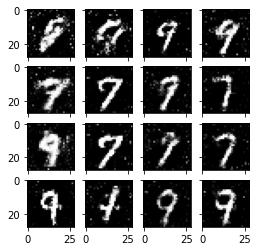

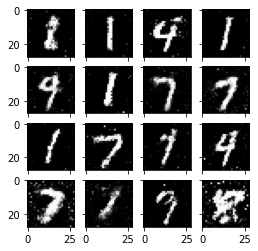

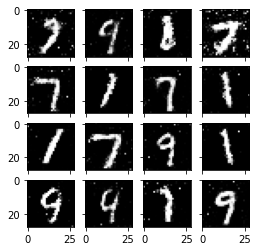

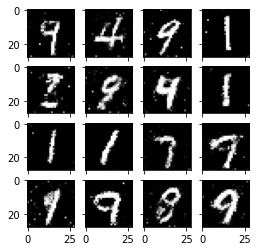

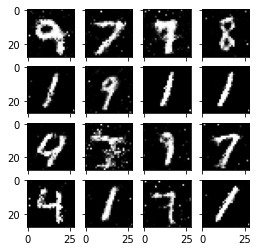

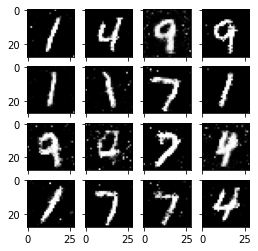

In [24]:
losses = training_loop(8000,128,1000)

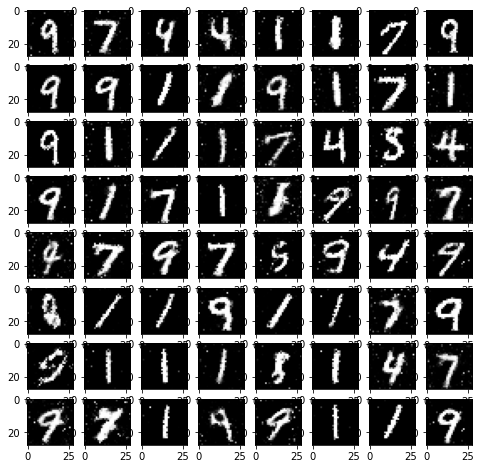

In [25]:
fig,ax = plt.subplots(8,8,figsize=(8,8))

for i in range(64):
  ax[i%8,i//8].imshow(generator.predict(np.random.randn(1,z)).reshape((28,28)),cmap="gray")

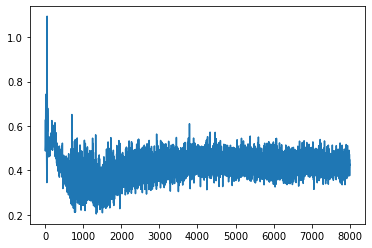

In [26]:
plt.plot(range(len(losses)),losses)

### NS-GAN DC-Generator Dense-Discriminator

In [31]:
th = 0.05
z = 256

discriminator = keras.Sequential()
discriminator.add(Reshape((784,),input_shape=(28,28,1)))
discriminator.add(Dense(1024))
discriminator.add(LeakyReLU(th))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(th))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(th))
discriminator.add(Dense(64))
discriminator.add(LeakyReLU(th))
discriminator.add(Dense(1,activation="sigmoid"))

discriminator.compile(loss = "binary_crossentropy",optimizer = keras.optimizers.RMSprop(0.0005),metrics = ["acc"])
discriminator.trainable = False

generator = keras.Sequential()
generator.add(Dense(7*7*256,input_dim = z))
generator.add(Reshape((7,7,256)))
generator.add(LeakyReLU(th))
generator.add(Conv2DTranspose(1024,(3,3),(2,2),padding="same"))
generator.add(LeakyReLU(th))
generator.add(Conv2DTranspose(256,(3,3),(1,1),padding="same"))
generator.add(LeakyReLU(th))
generator.add(Conv2DTranspose(1,(5,5),(2,2),padding="same",activation = "tanh"))

gan = keras.Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss = "binary_crossentropy",optimizer = keras.optimizers.RMSprop((0.0005)),metrics=["acc"])

assert ((gan.layers[0].trainable==True) and (gan.layers[1].trainable==False))

0
0.5532083511352539 0.5
[0.7121113538742065, 0.0]

1200
0.6108744144439697 0.6875
[1.0903301239013672, 0.1875]

2400
0.5655870735645294 0.6640625
[1.1362566947937012, 0.109375]

3600
0.601762592792511 0.6015625
[1.1274893283843994, 0.140625]

4800
0.5313311815261841 0.6875
[1.1666697263717651, 0.140625]

6000
0.5592736750841141 0.625
[1.125525712966919, 0.171875]

7200
0.5459011793136597 0.7109375
[1.0667774677276611, 0.15625]



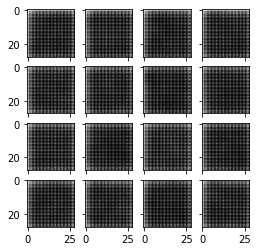

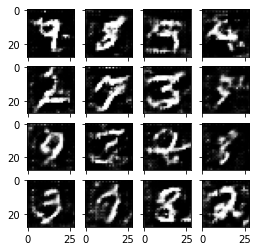

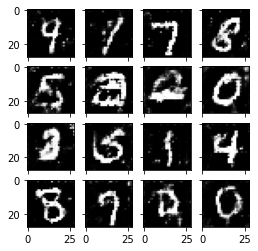

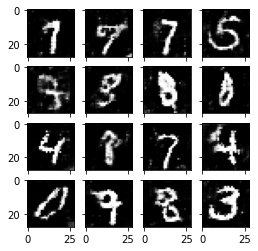

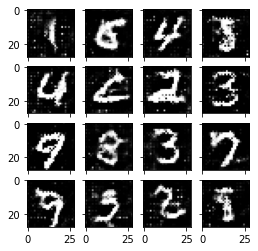

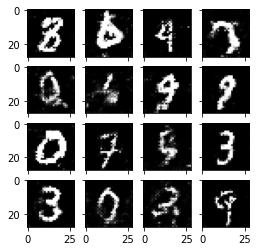

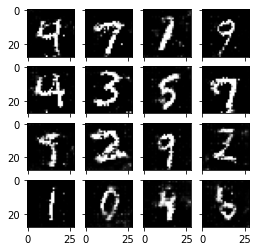

In [32]:
losses = training_loop(8000,64,1200)

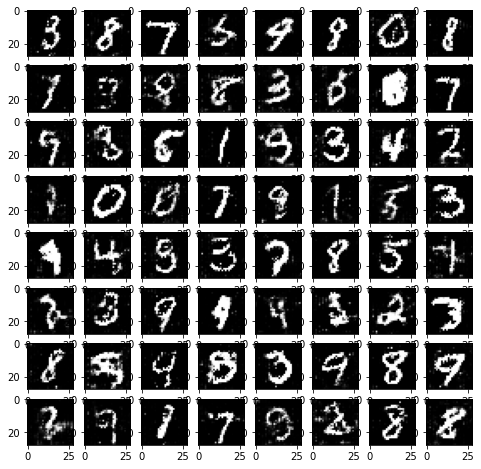

In [33]:
fig,ax = plt.subplots(8,8,figsize=(8,8))

for i in range(64):
  ax[i%8,i//8].imshow(generator.predict(np.random.randn(1,z)).reshape((28,28)),cmap="gray")

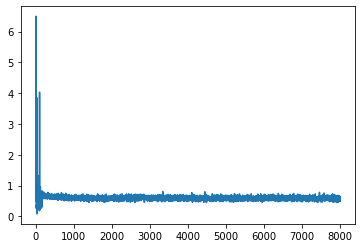

In [34]:
plt.plot(range(len(losses)),losses)

### NS-GAN DCGAN

In [35]:
th = 0.05
z = 256

discriminator = keras.Sequential()
discriminator.add(Conv2D(64,(5,5),(2,2),"same"))
discriminator.add(LeakyReLU(th))
discriminator.add(Conv2D(256,(5,5),(2,2),"same"))
discriminator.add(LeakyReLU(th))
discriminator.add(Conv2D(1024,(3,3),(2,2),"same"))
discriminator.add(LeakyReLU(th))
discriminator.add(Flatten())
discriminator.add(Dense(1,activation="sigmoid"))

discriminator.compile(loss = "binary_crossentropy",optimizer = keras.optimizers.RMSprop(0.0001),metrics = ["acc"])
discriminator.trainable = False

generator = keras.Sequential()
generator.add(Dense(7*7*256,input_dim = z))
generator.add(Reshape((7,7,256)))
generator.add(LeakyReLU(th))
generator.add(Conv2DTranspose(1024,(3,3),(2,2),padding="same"))
generator.add(LeakyReLU(th))
generator.add(Conv2DTranspose(256,(3,3),(1,1),padding="same"))
generator.add(LeakyReLU(th))
generator.add(Conv2DTranspose(1,(5,5),(2,2),padding="same",activation="tanh"))

gan = keras.Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss = "binary_crossentropy",optimizer = keras.optimizers.RMSprop((0.001)),metrics=["acc"])

assert ((gan.layers[0].trainable==True) and (gan.layers[1].trainable==False))

0
0.698516458272934 0.21875
[0.6900964975357056, 1.0]

1500
0.6885302364826202 0.609375
[0.7004708051681519, 0.40625]

3000
0.6627824902534485 0.625
[0.7825645208358765, 0.171875]

4500
0.6164949834346771 0.640625
[0.9127019047737122, 0.234375]

6000
0.6378645598888397 0.65625
[1.1372759342193604, 0.171875]

7500
0.5501408874988556 0.6875
[1.095130205154419, 0.296875]



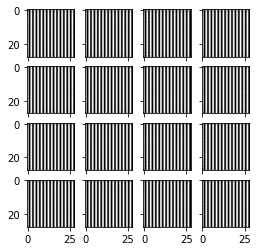

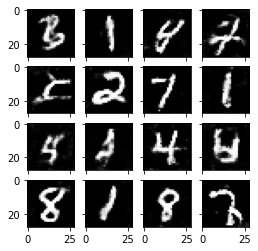

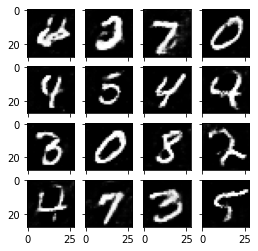

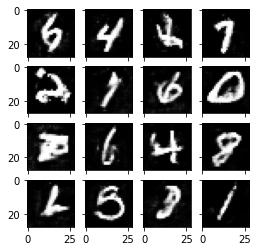

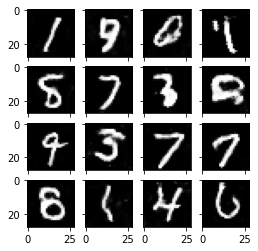

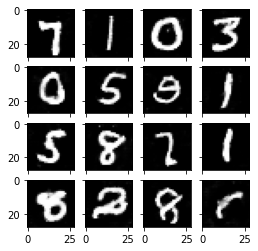

In [36]:
losses = training_loop(8000,64,1500)

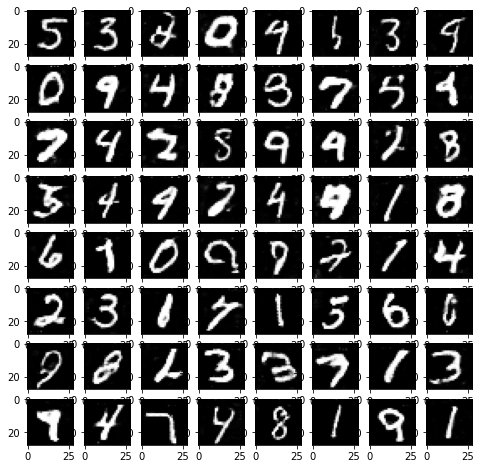

In [37]:
fig,ax = plt.subplots(8,8,figsize=(8,8))

for i in range(64):
  ax[i%8,i//8].imshow(generator.predict(np.random.randn(1,z)).reshape((28,28)),cmap="gray")

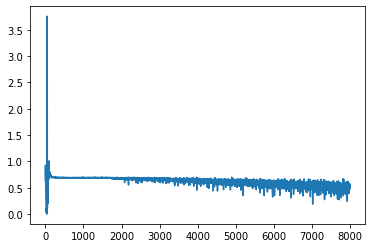

In [38]:
plt.plot(range(len(losses)),losses)

## WGAN

It uses Earth-Mover distance to calculate divergence between two probability distribution.  

Being the weakest among KL,JS,TV, implies generator that may not converge under other metrics may converge under EM,implying better stability of models. 

However, it imposes other constraints which reduces the efficiency of generator model.

Hyperparameters to tune:

1.   n_critic: Number of time critic must be trained to maximize the loss.The EM distance is hard to calculate and that is why critic is designed to use Kantrovich_Rubinstein inequality which requires critic to be Lipschitz.The maximum value of loss estimates the actual EM distance between real and predicted probability distribution.
2.   clip_value: The weights of critic must be clipped for making it Lipschitz function.This weakens the discriminator's performance and that is why it sometimes gives worse result than NSGAN.The more the value of clip the more n_critic value required for critic's convergence, the less the value of clip the worse critic performs.
3.   Learning_rate:Non-momentum optimizers are used with very low learning rate.



In [39]:
def EM(labels,logits):
  return - tf.reduce_sum(labels * logits) / (tf.reduce_sum(labels) + 1e-10)  + tf.reduce_sum((1. - labels) * (logits)) / (tf.reduce_sum((1. - labels)) + 1e-10)

In [40]:
def wan_train(n_iter,n_critic,batch_size,sampling_interval):
  losses = []
  for i in range(n_iter+1):
    for j in range(n_critic):
      ind = np.random.randint(len(xt),size =batch_size)
      losses.append(-discriminator.train_on_batch(np.concatenate([xt[ind],generator(np.random.randn(batch_size,z))],axis=0),np.concatenate([np.ones(batch_size),np.zeros(batch_size)],axis=0)))
    gan.train_on_batch(np.random.randn(batch_size,z),np.ones(batch_size))
    if i % sampling_interval == 0:
      print(i,losses[-1])
      sample_images(generator)  
  return losses

In [41]:
class clip(keras.constraints.Constraint):
  def __init__(self,val,**kwargs):
    super().__init__(**kwargs)
    self.val = val
  def __call__(self,weights):
    return tf.clip_by_value(weights,-self.val,self.val)

### WGAN Dense_generator Dense_discriminator

In [42]:
th = 0.5
z = 256
cl = 0.001

discriminator = keras.Sequential()
discriminator.add(Reshape((784,),input_shape=(28,28,1)))
discriminator.add(Dense(1024,kernel_constraint=clip(cl),bias_constraint=clip(cl)))
discriminator.add(LeakyReLU(th))
discriminator.add(Dense(512,kernel_constraint=clip(cl),bias_constraint=clip(cl)))
discriminator.add(LeakyReLU(th))
discriminator.add(Dense(256,kernel_constraint=clip(cl),bias_constraint=clip(cl)))
discriminator.add(LeakyReLU(th))
discriminator.add(Dense(1,kernel_constraint=clip(cl),bias_constraint=clip(cl)))

discriminator.compile(loss = EM,optimizer = keras.optimizers.RMSprop(0.00005))
discriminator.trainable = False

generator = keras.Sequential()
generator.add(Dense(256,input_dim = z))
generator.add(LeakyReLU(th))
generator.add(Dense(512,input_dim=z))
generator.add(LeakyReLU(th))
generator.add(Dense(1024))
generator.add(LeakyReLU(th))
generator.add(Dense(784,activation ="tanh"))
generator.add(Reshape((28,28,1)))

gan = keras.Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss = EM,optimizer = keras.optimizers.RMSprop((0.0005)))

assert ((gan.layers[0].trainable==True) and (gan.layers[1].trainable==False))

0 4.185969828540692e-07
1000 7.473165169358253e-05
2000 5.572859663516283e-05
3000 4.938512574881315e-06
4000 1.322633761446923e-05
5000 1.3454817235469818e-05
6000 0.0002583183813840151
7000 7.837501470930874e-05
8000 4.343048203736544e-06
9000 -3.479723818600178e-05
10000 0.00014505299623124301


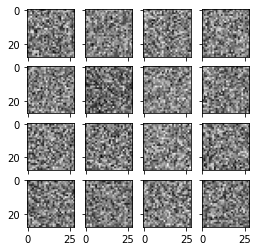

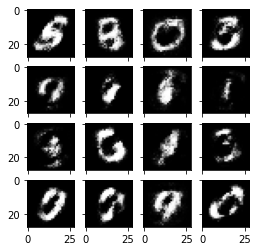

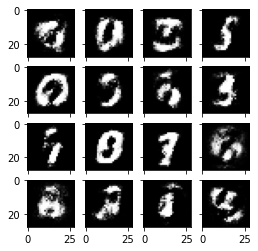

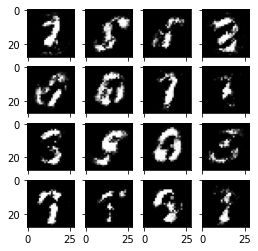

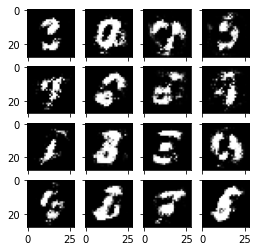

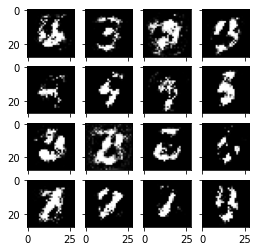

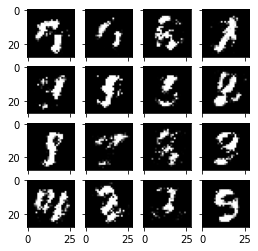

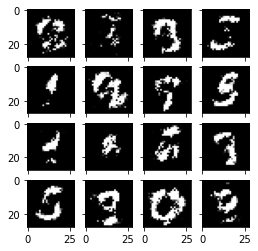

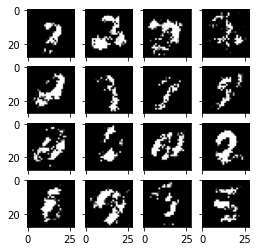

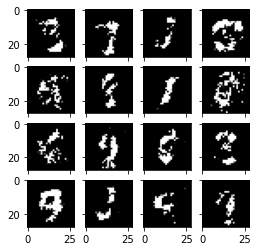

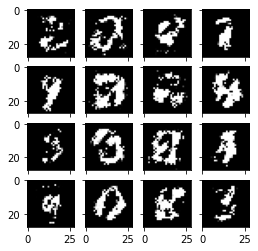

In [43]:
losses = wan_train(n_iter=10000,n_critic=5,batch_size=64,sampling_interval=1000)

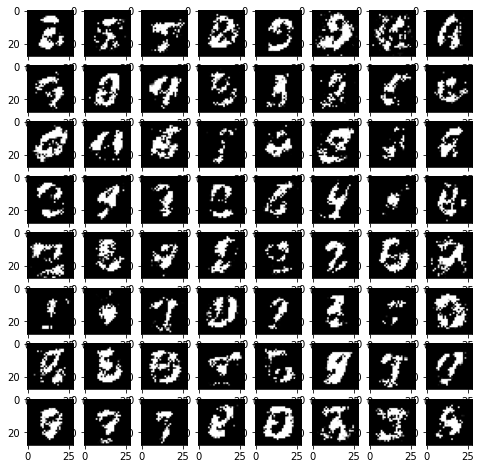

In [44]:
fig,ax = plt.subplots(8,8,figsize=(8,8))

for i in range(64):
  ax[i%8,i//8].imshow(generator.predict(np.random.randn(1,z)).reshape((28,28)),cmap="gray")

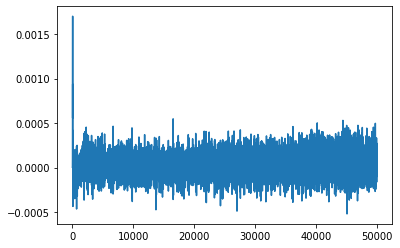

In [45]:
plt.plot(range(len(losses[100:])),losses[100:])

### WGAN DC-Generator dense-Discriminator

In [46]:
th = 0.05
z = 256
cl = 0.01

discriminator = keras.Sequential()
discriminator.add(Reshape((784,),input_shape=(28,28,1)))
discriminator.add(Dense(1024,kernel_constraint=clip(cl),bias_constraint=clip(cl)))
discriminator.add(LeakyReLU(th))
discriminator.add(Dense(512,kernel_constraint=clip(cl),bias_constraint=clip(cl)))
discriminator.add(LeakyReLU(th))
discriminator.add(Dense(256,kernel_constraint=clip(cl),bias_constraint=clip(cl)))
discriminator.add(LeakyReLU(th))
discriminator.add(Dense(64,kernel_constraint=clip(cl),bias_constraint=clip(cl)))
discriminator.add(LeakyReLU(th))
discriminator.add(Dense(1,kernel_constraint=clip(cl),bias_constraint=clip(cl)))

discriminator.compile(loss = EM,optimizer = keras.optimizers.RMSprop(0.00005))
discriminator.trainable = False

generator = keras.Sequential()
generator.add(Dense(7*7*256,input_dim = z))
generator.add(LeakyReLU(th))
generator.add(Reshape((7,7,256)))
generator.add(Conv2DTranspose(512,(5,5),(2,2),padding="same"))
generator.add(LeakyReLU(th))
generator.add(Conv2DTranspose(64,(5,5),(1,1),padding="same"))
generator.add(LeakyReLU(th))
generator.add(Conv2DTranspose(1,(5,5),(2,2),padding="same",activation = "tanh"))

gan = keras.Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss = EM,optimizer = keras.optimizers.RMSprop((0.0005)))

assert ((gan.layers[0].trainable==True) and (gan.layers[1].trainable==False))

0 0.00010152057802770287
1000 0.15498441457748413
2000 0.12858927249908447
3000 0.13491955399513245
4000 0.08798420429229736
5000 0.009856939315795898
6000 0.1600232720375061
7000 0.15354356169700623
8000 0.029998064041137695
9000 0.07624650001525879
10000 0.03767387568950653


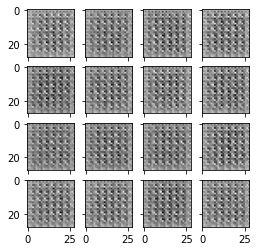

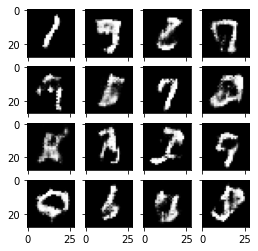

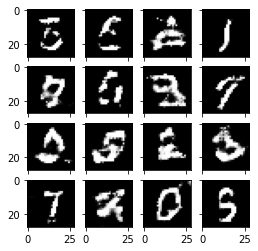

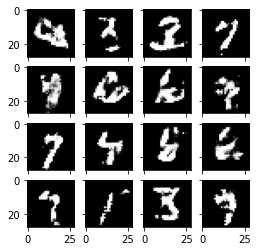

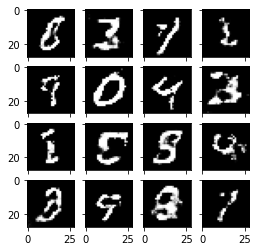

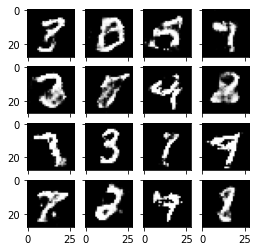

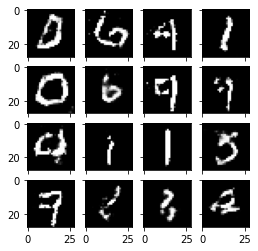

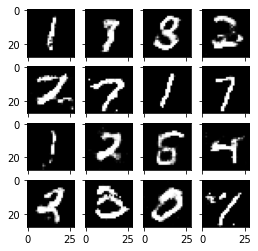

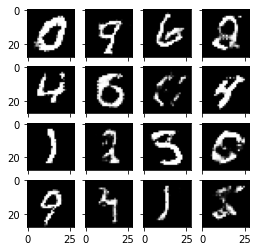

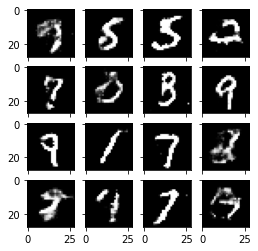

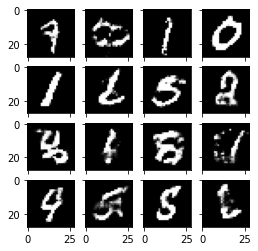

In [47]:
losses = wan_train(n_iter=10000,n_critic=5,batch_size=64,sampling_interval=1000)

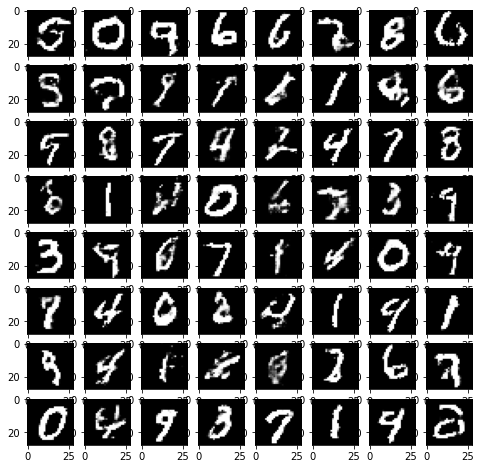

In [48]:
fig,ax = plt.subplots(8,8,figsize=(8,8))

for i in range(64):
  ax[i%8,i//8].imshow(generator.predict(np.random.randn(1,z)).reshape((28,28)),cmap="gray")

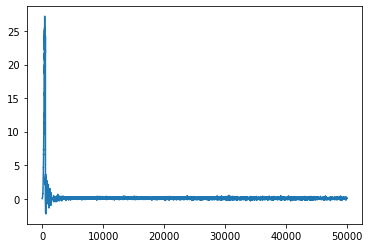

In [49]:
plt.plot(range(len(losses[100:])),losses[100:])

In [62]:
th = 0.05
z = 256
cl = 0.01

discriminator = keras.Sequential()
discriminator.add(Reshape((784,),input_shape=(28,28,1)))
discriminator.add(Dense(1024,kernel_constraint=clip(cl),bias_constraint=clip(cl)))
discriminator.add(BatchNormalization(axis=-1))
discriminator.add(LeakyReLU(th))
discriminator.add(Dense(256,kernel_constraint=clip(cl),bias_constraint=clip(cl)))
discriminator.add(BatchNormalization(axis=-1))
discriminator.add(LeakyReLU(th))
discriminator.add(Dense(64,kernel_constraint=clip(cl),bias_constraint=clip(cl)))
discriminator.add(BatchNormalization(axis=-1))
discriminator.add(LeakyReLU(th))
discriminator.add(Dense(1,kernel_constraint=clip(cl),bias_constraint=clip(cl)))

discriminator.compile(loss = EM,optimizer = keras.optimizers.RMSprop(0.00005))
discriminator.trainable = False

generator = keras.Sequential()
generator.add(Dense(7*7*256,input_dim = z))
generator.add(LeakyReLU(th))
generator.add(Reshape((7,7,256)))
generator.add(Conv2DTranspose(512,(7,7),(2,2),padding="same"))
generator.add(LeakyReLU(th))
generator.add(Conv2DTranspose(64,(5,5),(1,1),padding="same"))
generator.add(LeakyReLU(th))
generator.add(Conv2DTranspose(1,(5,5),(2,2),padding="same",activation = "tanh"))

gan = keras.Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss = EM,optimizer = keras.optimizers.RMSprop((0.0005)))

assert ((gan.layers[0].trainable==True) and (gan.layers[1].trainable==False))

0 0.2726249098777771
1000 0.8070931434631348
2000 1.0189661979675293
3000 1.0567176342010498
4000 1.300753116607666
5000 1.4375195503234863
6000 1.7200287580490112


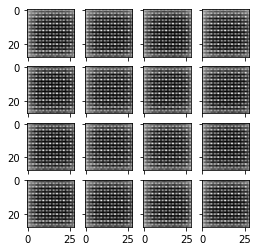

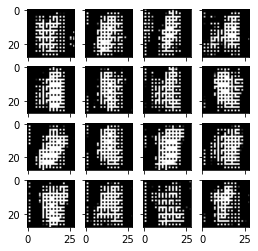

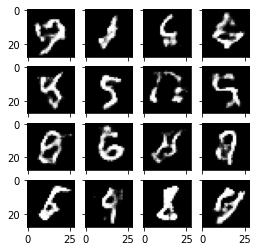

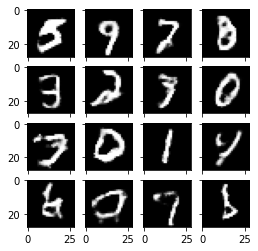

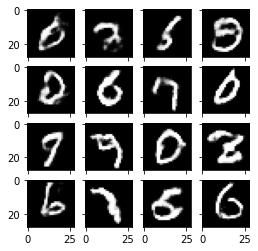

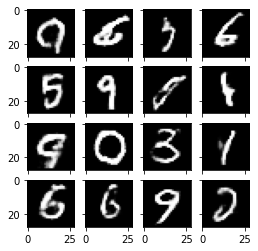

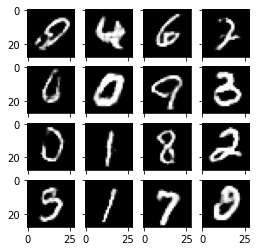

In [63]:
losses = wan_train(n_iter=6000,n_critic=5,batch_size=64,sampling_interval=1000)

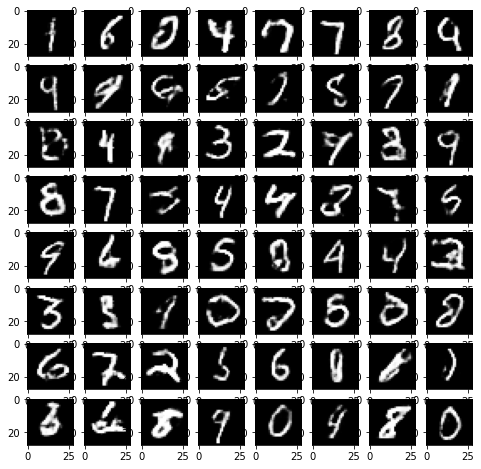

In [64]:
fig,ax = plt.subplots(8,8,figsize=(8,8))

for i in range(64):
  ax[i%8,i//8].imshow(generator.predict(np.random.randn(1,z)).reshape((28,28)),cmap="gray")

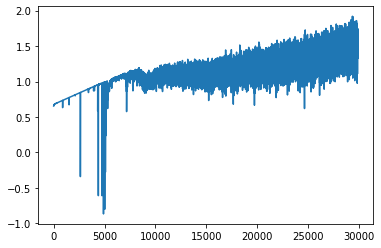

In [65]:
plt.plot(range(len(losses[100:])),losses[100:])

### WGAN DC-Generator DC-Discriminator

0 1.1780736446380615
1000 3.3319225311279297
2000 3.05726957321167
3000 4.698919296264648
4000 6.398873329162598
5000 3.408238410949707
6000 4.681191444396973
7000 5.948064804077148
8000 6.002986907958984
9000 4.554515838623047
10000 7.70539665222168


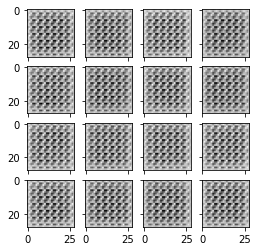

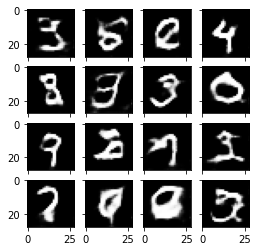

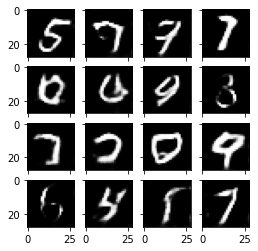

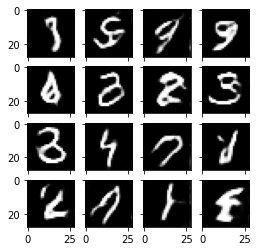

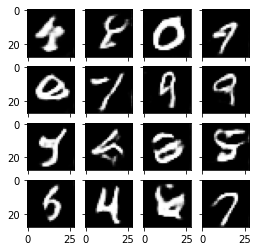

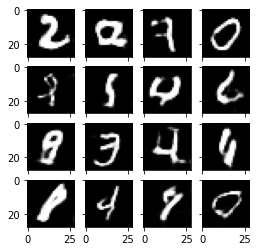

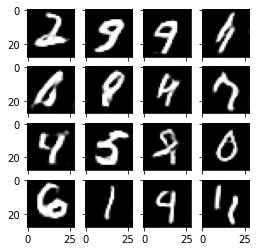

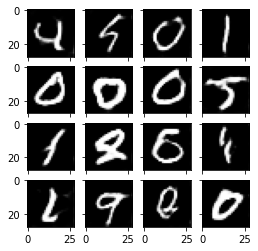

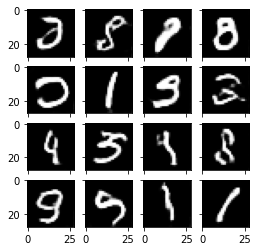

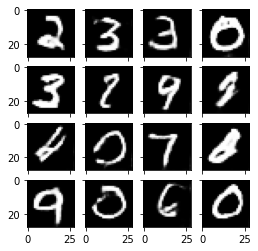

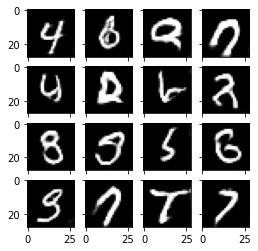

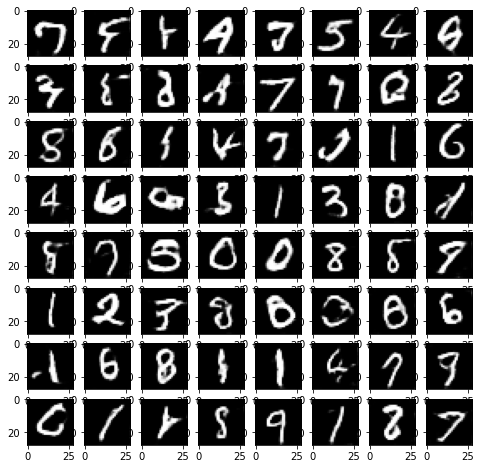

In [ ]:
z = 100
val = 0.005
act = 0.3
discriminator = keras.Sequential()
discriminator.add(Conv2D(32,(7,7),(2,2),"valid",input_shape = (28,28,1),kernel_constraint= clip(val),bias_constraint=clip(val)))
discriminator.add(BatchNormalization(axis=-1))
discriminator.add(LeakyReLU(act))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(64,(5,5),(1,1),"valid",kernel_constraint= clip(val),bias_constraint=clip(val)))
discriminator.add(BatchNormalization(axis=-1))
discriminator.add(LeakyReLU(act))
discriminator.add(Dropout(0.2))
discriminator.add(Conv2D(256,(5,5),(2,2),"valid",kernel_constraint= clip(val),bias_constraint=clip(val)))
discriminator.add(BatchNormalization(axis=-1))
discriminator.add(LeakyReLU(act))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1,kernel_constraint = clip(val),bias_constraint = clip(val)))
discriminator.compile(loss=EM,optimizer = keras.optimizers.RMSprop(lr = 0.00005))

generator = keras.Sequential()
generator.add(Dense(7*7*256,input_dim = 100))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((7,7,256)))
generator.add(Conv2DTranspose(512,(4,4),(2,2),"same"))
generator.add(BatchNormalization(axis=-1))
generator.add(LeakyReLU(act))
generator.add(Conv2DTranspose(64,(5,5),(1,1),"same"))
generator.add(BatchNormalization(axis=-1))
generator.add(LeakyReLU(act))
generator.add(Conv2DTranspose(1,(4,4),(2,2),"same",activation="tanh"))

gan = keras.Sequential([generator,discriminator])
discriminator.trainable = False
gan.compile(loss=EM,optimizer = keras.optimizers.RMSprop(lr = 0.0005))

losses = wan_train(n_iter=10000,n_critic=5,batch_size=64,sampling_interval=1000)

fig,ax = plt.subplots(8,8,figsize=(8,8))

for i in range(64):
  ax[i%8,i//8].imshow(generator.predict(np.random.randn(1,z)).reshape((28,28)),cmap="gray")

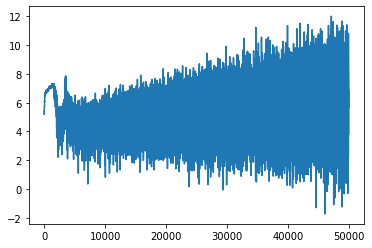

In [ ]:
plt.plot(range(len(losses[100:])),losses[100:])

0 1.2964661121368408
1000 5.100076675415039
2000 5.598541259765625
3000 4.1034698486328125
4000 6.661106109619141
5000 6.625357627868652
6000 5.6277642250061035
7000 8.869678497314453
8000 8.124408721923828
9000 9.309633255004883
10000 7.611923694610596


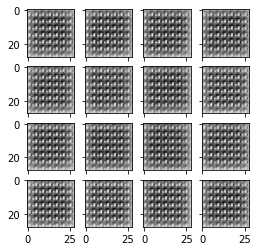

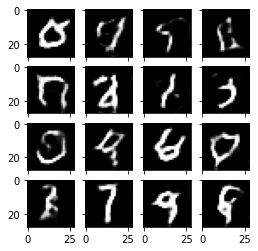

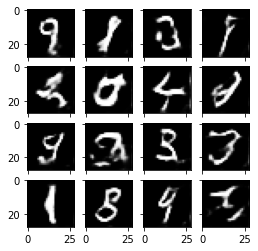

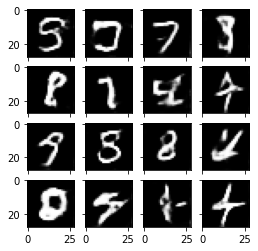

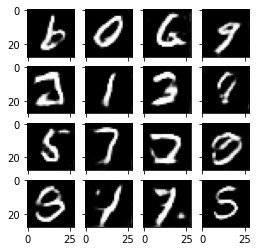

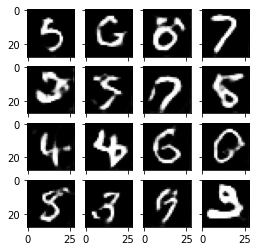

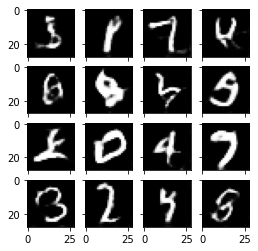

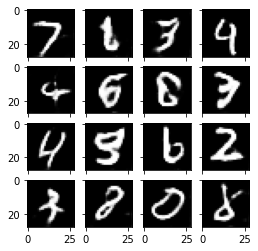

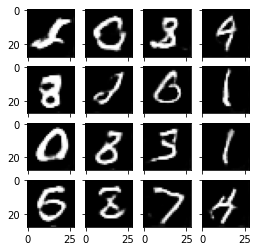

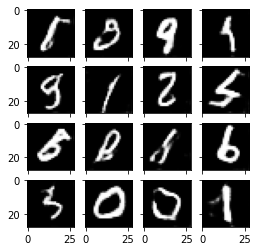

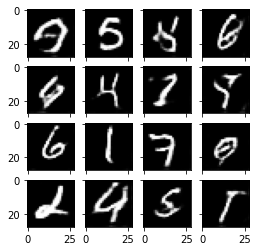

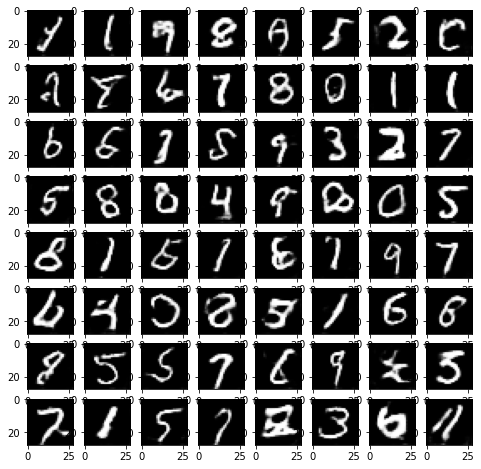

In [ ]:
z = 256
val = 0.005
act = 0.3
discriminator = keras.Sequential()
discriminator.add(Conv2D(32,(7,7),(2,2),"valid",input_shape = (28,28,1),kernel_constraint= clip(val),bias_constraint=clip(val)))
discriminator.add(BatchNormalization(axis=-1))
discriminator.add(LeakyReLU(act))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(64,(5,5),(1,1),"valid",kernel_constraint= clip(val),bias_constraint=clip(val)))
discriminator.add(BatchNormalization(axis=-1))
discriminator.add(LeakyReLU(act))
discriminator.add(Dropout(0.2))
discriminator.add(Conv2D(256,(5,5),(2,2),"valid",kernel_constraint= clip(val),bias_constraint=clip(val)))
discriminator.add(BatchNormalization(axis=-1))
discriminator.add(LeakyReLU(act))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1,kernel_constraint = clip(val),bias_constraint = clip(val)))
discriminator.compile(loss=EM,optimizer = keras.optimizers.RMSprop(lr = 0.00005))

generator = keras.Sequential()
generator.add(Dense(7*7*256,input_dim = 256))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((7,7,256)))
generator.add(Conv2DTranspose(512,(4,4),(2,2),"same"))
generator.add(BatchNormalization(axis=-1))
generator.add(LeakyReLU(act))
generator.add(Conv2DTranspose(64,(5,5),(1,1),"same"))
generator.add(BatchNormalization(axis=-1))
generator.add(LeakyReLU(act))
generator.add(Conv2DTranspose(1,(4,4),(2,2),"same",activation="tanh"))

gan = keras.Sequential([generator,discriminator])
discriminator.trainable = False
gan.compile(loss=EM,optimizer = keras.optimizers.RMSprop(lr = 0.0005))

losses = wan_train(n_iter=10000,n_critic=5,batch_size=64,sampling_interval=1000)

fig,ax = plt.subplots(8,8,figsize=(8,8))

for i in range(64):
  ax[i%8,i//8].imshow(generator.predict(np.random.randn(1,z)).reshape((28,28)),cmap="gray")

0 1.100664734840393
1000 4.3457350730896
2000 4.5578813552856445
3000 5.361769676208496
4000 4.779849529266357
5000 5.6027936935424805
6000 4.098121643066406
7000 6.49394416809082
8000 6.582489967346191
9000 3.9762556552886963
10000 9.54177474975586


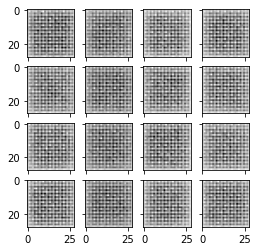

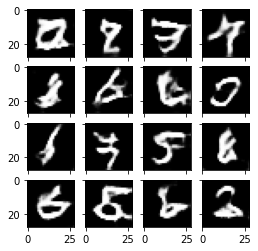

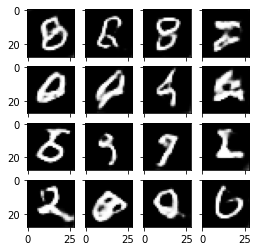

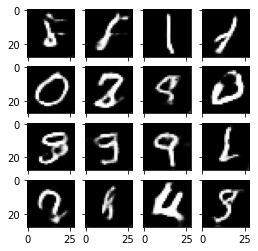

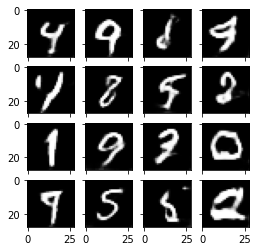

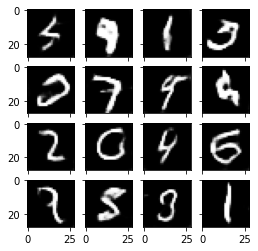

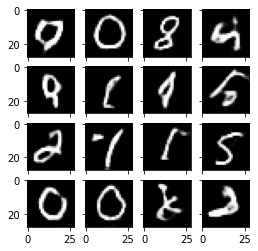

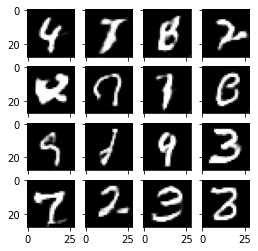

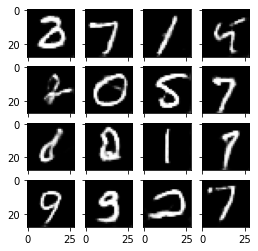

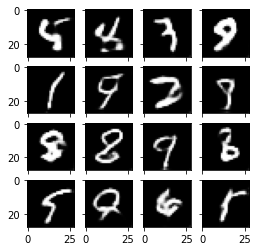

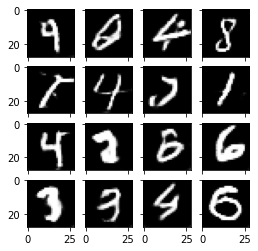

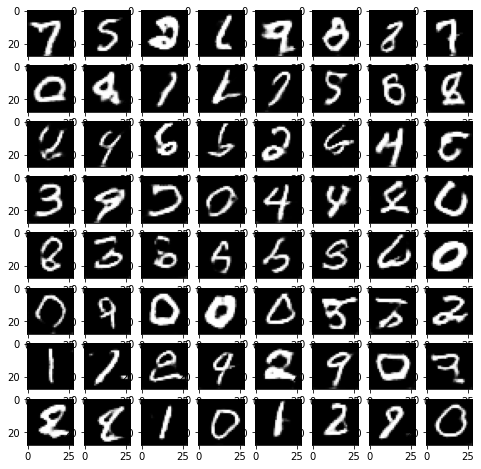

In [ ]:
z = 100
val = 0.005
act = 0.3
discriminator = keras.Sequential()
discriminator.add(Conv2D(32,(7,7),(2,2),"valid",input_shape = (28,28,1),kernel_constraint= clip(val),bias_constraint=clip(val)))
discriminator.add(BatchNormalization(axis=-1))
discriminator.add(LeakyReLU(act))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(64,(5,5),(1,1),"valid",kernel_constraint= clip(val),bias_constraint=clip(val)))
discriminator.add(BatchNormalization(axis=-1))
discriminator.add(LeakyReLU(act))
discriminator.add(Dropout(0.2))
discriminator.add(Conv2D(256,(5,5),(2,2),"valid",kernel_constraint= clip(val),bias_constraint=clip(val)))
discriminator.add(BatchNormalization(axis=-1))
discriminator.add(LeakyReLU(act))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1,kernel_constraint = clip(val),bias_constraint = clip(val)))
discriminator.compile(loss=EM,optimizer = keras.optimizers.RMSprop(lr = 0.00005))

generator = keras.Sequential()
generator.add(Dense(7*7*512,input_dim = 100))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((7,7,512)))
generator.add(Conv2DTranspose(128,(4,4),(2,2),"same"))
generator.add(LeakyReLU(act))
generator.add(Conv2DTranspose(128,(5,5),(1,1),"same"))
generator.add(LeakyReLU(act))
generator.add(Conv2DTranspose(1,(4,4),(2,2),"same",activation="tanh"))

gan = keras.Sequential([generator,discriminator])
discriminator.trainable = False
gan.compile(loss=EM,optimizer = keras.optimizers.RMSprop(lr = 0.0005))

losses = wan_train(n_iter=10000,n_critic=5,batch_size=64,sampling_interval=1000)

fig,ax = plt.subplots(8,8,figsize=(8,8))

for i in range(64):
  ax[i%8,i//8].imshow(generator.predict(np.random.randn(1,z)).reshape((28,28)),cmap="gray")